In [11]:
import requests
import pandas as pd

HOST = "https://api.census.gov/data"
year = "2019"
dataset = "cps/disability/jul"
base_url = "/".join([HOST, year, dataset])

# List of all state FIPS codes
state_fips = [
    "01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", 
    "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", 
    "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", 
    "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56"
]

# Column names to map to
col_names = [
    "labor_force_employment_status",
    "how_disability_affects_ability_to_work",
    "used_vocational_rehabilitation_agencies",
    "used_one_stop_career_centers",
    "used_the_ticket_to_work_program",
    "used_assistive_technology_act_prog",
    "used_ctr_for_indpt_living_for_ind_w_dis",
    "used_the_client_assistance_program",
    "used_any_other_employment_assistance_program",
    "how_helpful_vocational_rehab_agency",
    "how_helpful_one_stop_career_centers",
    "the_ticket_to_work_program_helpfulness",
    "ctr_for_indpdt_living_for_ind_w_dis_helpful",
    "other_employment_assist_program_helpful",
    "does_this_person_have_any_of_these_disability_conditions",
    "barrier_lack_of_education_or_training",
    "barrier_lack_of_job_counseling",
    "barrier_lack_of_transportation",
    "barrier_loss_of_government_assistance",
    "barrier_need_for_special_features",
    "barrier_employer_or_coworker_attitudes",
    "barrier_your_difficulty_with_disability",
    "barrier_other",
    "barrier_none",
    "demographics_race_of_respondent",
    "demographics_sex",
    "demographics_age",
    "household_total_family_income_past_12_months",
    "state",
    "county"
]

# Prepare query predicates
predicates = {}
get_vars = [
    "PEMLR", "PESD1", "PESD6A", "PESD6B", "PESD6C", "PESD6D", "PESD6E", 
    "PESD6F", "PESD6G", "PESD7A", "PESD7B", "PESD7C", "PESD7E", "PESD7G", 
    "PRDISFLG", "PESD41", "PESD42", "PESD43", "PESD44", "PESD45", "PESD46", 
    "PESD47", "PESD48", "PESD49", "PTDTRACE", "PESEX", "PRTAGE", "HEFAMINC"
]
predicates["get"] = ",".join(get_vars)

# Make separate requests for each state
data_frames = []
for state in state_fips:
    predicates["for"] = "county:*"
    predicates["in"] = f"state:{state}"
    r = requests.get(base_url, params=predicates)
    
    # Convert response to DataFrame if the request is successful
    if r.status_code == 200:
        data = r.json()
        df = pd.DataFrame(data[1:], columns=col_names)  # Map to col_names
        data_frames.append(df)
    else:
        print(f"Failed for state: {state}, status code: {r.status_code}")

# Combine all states into a single DataFrame
final_df = pd.concat(data_frames, ignore_index=True)

print(final_df.head())

# Save the DataFrame to a CSV file
final_df.to_csv("raw-us-data.csv", index=False)



  labor_force_employment_status how_disability_affects_ability_to_work  \
0                             5                                     -1   
1                             5                                     -1   
2                             1                                     -1   
3                             5                                     -1   
4                             1                                     -1   

  used_vocational_rehabilitation_agencies used_one_stop_career_centers  \
0                                      -1                           -1   
1                                      -1                           -1   
2                                      -1                           -1   
3                                      -1                           -1   
4                                      -1                           -1   

  used_the_ticket_to_work_program used_assistive_technology_act_prog  \
0                              -1     

In [13]:
data = pd.read_csv('raw-us-data.csv',header=0)
# drop all records that are not in the universe of labor_force_employment_status
filteredData = data[data["labor_force_employment_status"] != -1]
filteredData = filteredData.loc[:,  ~filteredData.columns.str.contains('^Unnamed')]

print(len(filteredData))
# drop all records that do not have a dissability
filteredData = filteredData[filteredData["does_this_person_have_any_of_these_disability_conditions"] == 1]
print(len(filteredData))

# categorize output variable into binary options
filteredData["labor_force_employment_status"] = filteredData["labor_force_employment_status"].apply(lambda x: 1 if x == 1 or x == 2 else 0)

filteredData.to_csv("cleaned-us-data.csv")

95593
11953


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1957
           1       0.94      0.82      0.88       434

    accuracy                           0.96      2391
   macro avg       0.95      0.91      0.93      2391
weighted avg       0.96      0.96      0.96      2391



c:\anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


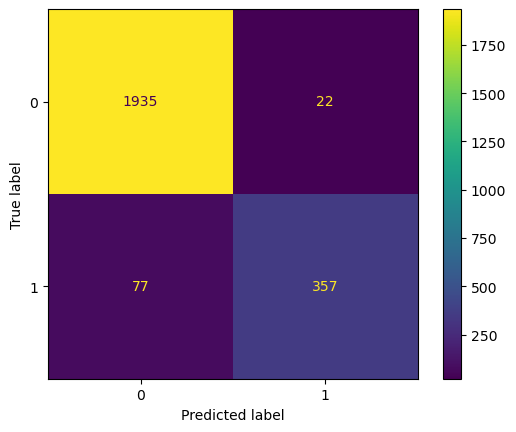

In [15]:
# Scikit logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

clf_log = LogisticRegression()
clf_log = clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_log.classes_)
disp.plot()
print(classification_report(y_test, y_pred))
 

[Text(0.6594894475481068, 0.9782608695652174, 'how_disability_affects_ability_to_work <= 0.0\ngini = 0.311\nsamples = 9562\nvalue = [7721, 1841]\nclass = Unemployed'),
 Text(0.6570065176908753, 0.9347826086956522, 'barrier_your_difficulty_with_disability <= 0.0\ngini = 0.095\nsamples = 8128\nvalue = [7721, 407]\nclass = Unemployed'),
 Text(0.6545235878336437, 0.8913043478260869, 'demographics_age <= 68.5\ngini = 0.308\nsamples = 2141\nvalue = [1734, 407]\nclass = Unemployed'),
 Text(0.3862798727498448, 0.8478260869565217, 'household_total_family_income_past_12_months <= 11.5\ngini = 0.397\nsamples = 1328\nvalue = [965, 363]\nclass = Unemployed'),
 Text(0.17327164804469275, 0.8043478260869565, 'demographics_age <= 43.5\ngini = 0.29\nsamples = 836\nvalue = [689, 147]\nclass = Unemployed'),
 Text(0.0702203600248293, 0.7608695652173914, 'household_total_family_income_past_12_months <= 6.5\ngini = 0.413\nsamples = 268\nvalue = [190, 78]\nclass = Unemployed'),
 Text(0.02094972067039106, 0.71

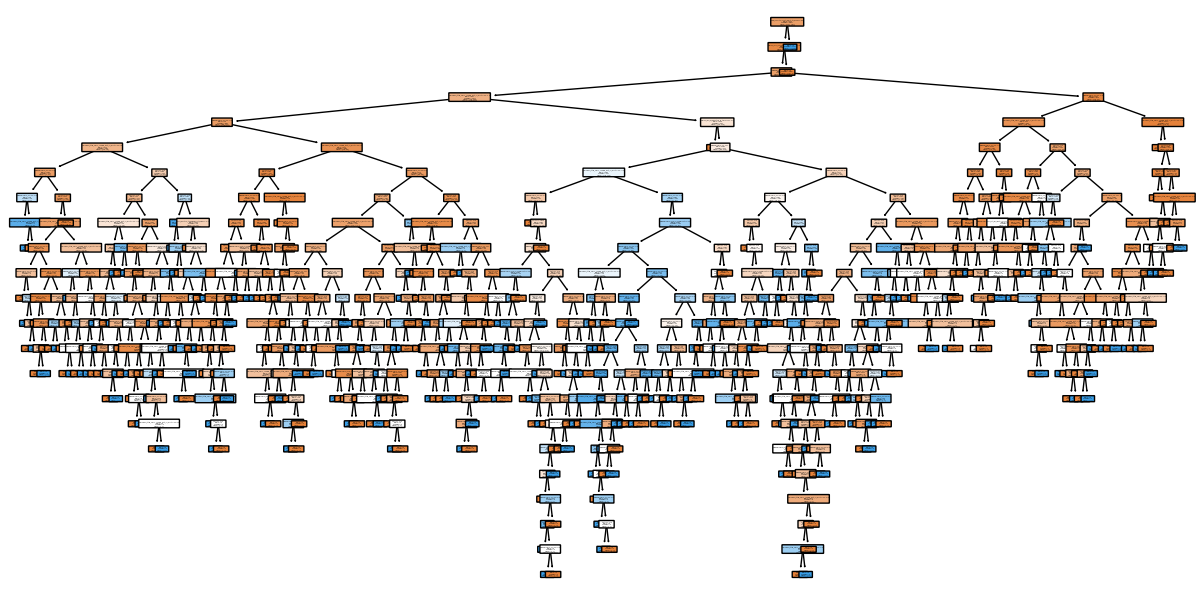

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]


X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf,
          filled=True,
          rounded=True,
          class_names=["Unemployed", "Employed"],
          feature_names=x_var.columns,
        )
 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1957
           1       0.85      0.87      0.86       434

    accuracy                           0.95      2391
   macro avg       0.91      0.92      0.91      2391
weighted avg       0.95      0.95      0.95      2391



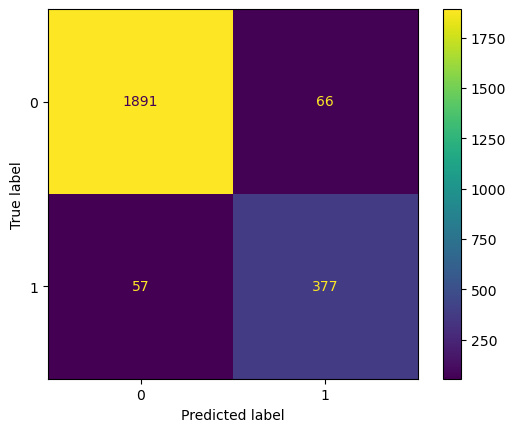

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

<Axes: xlabel='alpha'>

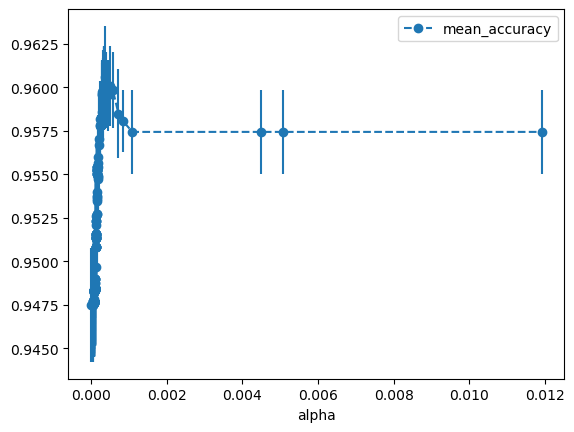

In [19]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # exclude maximum value for alpha because it is a trivial case

# array to store results of each fold during cross validation
alpha_loop_values = []

# For each candidate for alpha, run a 5-fold cross validation and store the mean, std, and accuracy in alpha_loop_variables
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# graph means and std of scores for each alpha value
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

In [20]:
ideal_ccp_alpha = alpha_results[
    (alpha_results['alpha'] > 0.000) & (alpha_results['alpha'] < 0.002)
].sort_values('mean_accuracy', ascending=False).iloc[0]['alpha']

ideal_ccp_alpha

0.0003729133500315661

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1957
           1       0.93      0.83      0.88       434

    accuracy                           0.96      2391
   macro avg       0.95      0.91      0.93      2391
weighted avg       0.96      0.96      0.96      2391



[Text(0.6025, 0.9545454545454546, 'how_disability_affects_ability_to_work <= 0.0\ngini = 0.311\nsamples = 9562\nvalue = [7721, 1841]\nclass = Unemployed'),
 Text(0.5625, 0.8636363636363636, 'barrier_need_for_special_features <= 0.0\ngini = 0.095\nsamples = 8128\nvalue = [7721, 407]\nclass = Unemployed'),
 Text(0.5225, 0.7727272727272727, 'demographics_age <= 68.5\ngini = 0.308\nsamples = 2141\nvalue = [1734, 407]\nclass = Unemployed'),
 Text(0.375, 0.6818181818181818, 'household_total_family_income_past_12_months <= 11.5\ngini = 0.397\nsamples = 1328\nvalue = [965, 363]\nclass = Unemployed'),
 Text(0.2, 0.5909090909090909, 'demographics_age <= 43.5\ngini = 0.29\nsamples = 836\nvalue = [689, 147]\nclass = Unemployed'),
 Text(0.16, 0.5, 'household_total_family_income_past_12_months <= 6.5\ngini = 0.413\nsamples = 268\nvalue = [190, 78]\nclass = Unemployed'),
 Text(0.08, 0.4090909090909091, 'demographics_age <= 20.5\ngini = 0.299\nsamples = 115\nvalue = [94, 21]\nclass = Unemployed'),
 Te

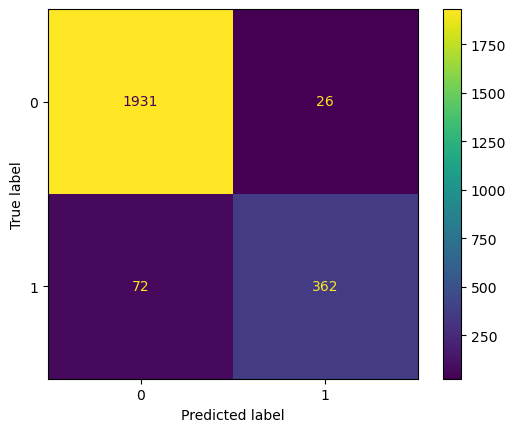

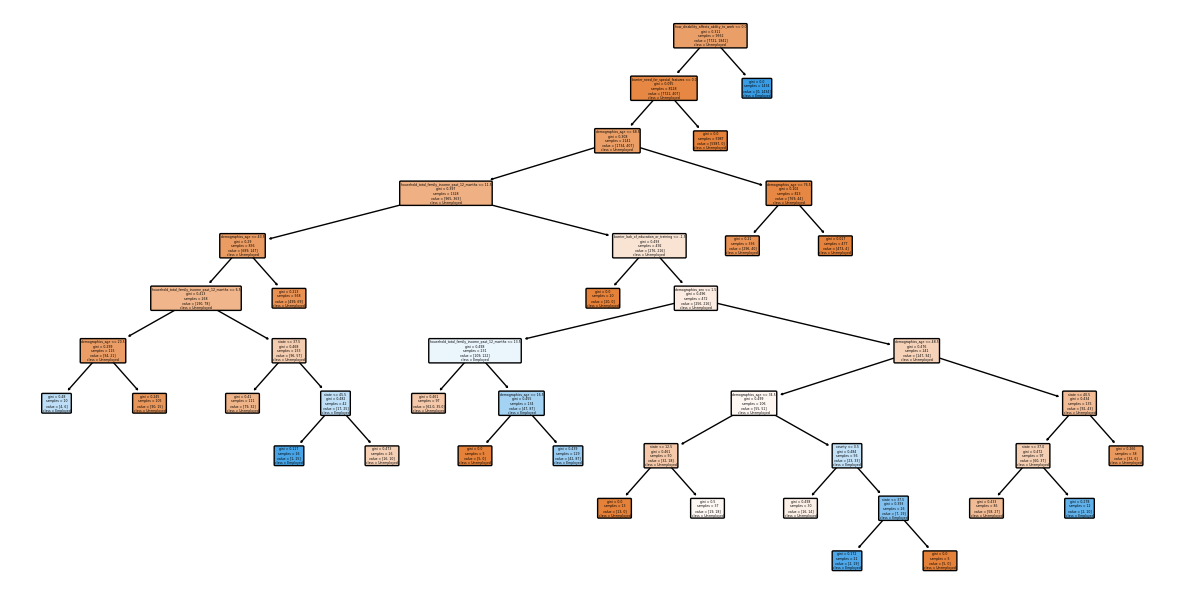

In [21]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42,
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_pred = clf_dt_pruned.predict(X_test)
new_cm = confusion_matrix(y_test, y_pred, labels=clf_dt_pruned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=new_cm, display_labels=clf_dt_pruned.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

# Plot the pruned tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["Unemployed", "Employed"],
          feature_names=x_var.columns,
        )

c:\anaconda\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1957
           1       0.94      0.84      0.89       434

    accuracy                           0.96      2391
   macro avg       0.95      0.91      0.93      2391
weighted avg       0.96      0.96      0.96      2391



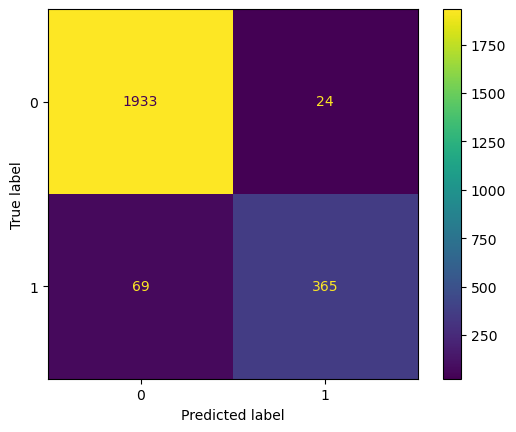

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

# With no hyperparameters
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
disp.plot()
print(classification_report(y_test, y_pred))


c:\anaconda\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1957
           1       0.95      0.82      0.88       434

    accuracy                           0.96      2391
   macro avg       0.96      0.91      0.93      2391
weighted avg       0.96      0.96      0.96      2391



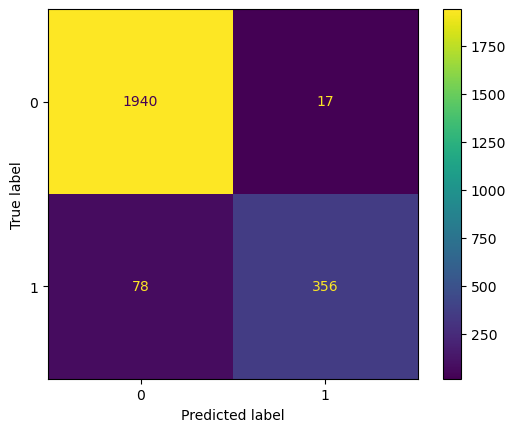

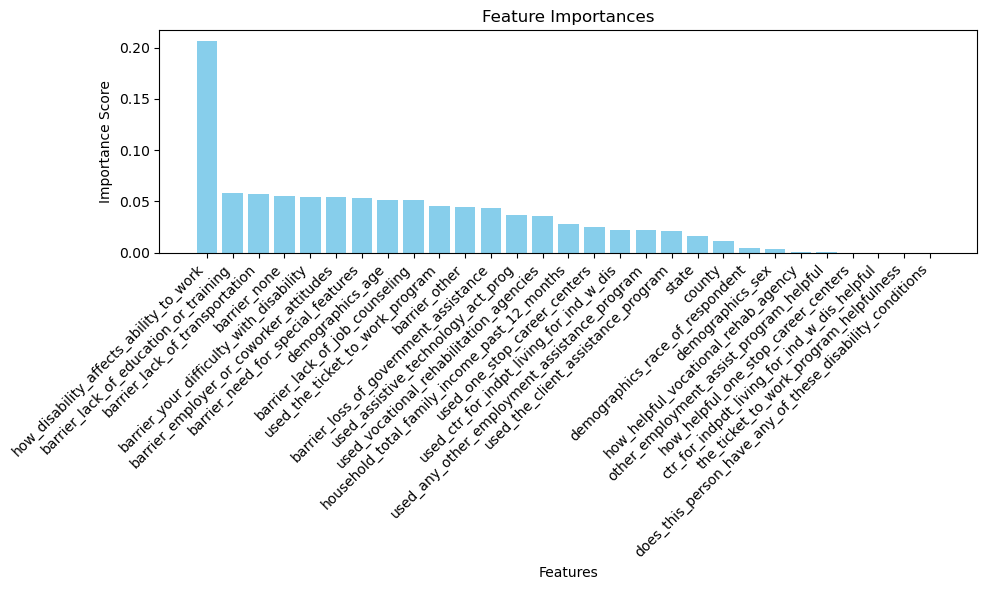

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# adding hyper parameters
clf_rf2 = RandomForestClassifier(n_estimators=1000,
                             criterion='entropy',
                             min_samples_split=10,
                             max_depth=14,
                             random_state=42)
clf_rf2.fit(X_train, y_train)

y_pred = clf_rf2.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf2.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

feature_importances = clf_rf2.feature_importances_
feature_names = list(X_train.columns)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importances")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Epoch 1
Epoch 51
Epoch 101
Epoch 151
Epoch 201
Epoch 251
Epoch 301
Epoch 351
Epoch 401
Epoch 451
Epoch 501
Epoch 551
Epoch 601
Epoch 651
Epoch 701
Epoch 751
Epoch 801
Epoch 851
Epoch 901
Epoch 951
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1957
           1       1.00      0.79      0.88       434

    accuracy                           0.96      2391
   macro avg       0.98      0.90      0.93      2391
weighted avg       0.96      0.96      0.96      2391



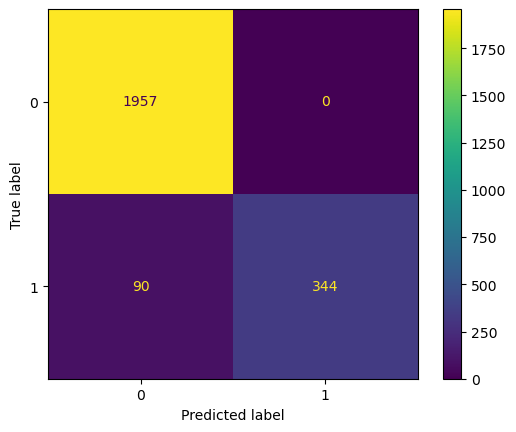

In [24]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_var)
y_var = y_var.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    x_scaled,
    y_var,
    test_size=0.2,
    random_state=42
)

input_features = X_train.shape[1]

class Net(nn.Module):

    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 270)
        self.fc2 = nn.Linear(270, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x

net = Net(input_features)

"""
Training Parameters
- Batch size is 50 to avoid overfitting, Training for 50 epochs with learning rate of 0.01
- Use Cross entropy loss function to calculate error during training (commonly used for binary classification)
- Use Adam optimizer to find gradients
"""

# Model params:
batch_size = 50
num_epochs = 1000
learning_rate = 0.01
batch_no = len(X_train) // batch_size

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


# Iterate for the number of epochs
for epoch in range(num_epochs):
    # Print the epoch number every 5 epochs
    if epoch % 50 == 0:
        print('Epoch {}'.format(epoch+1))

    # Shufle the datasets to randomize the data rows that
    # will be added to the batch and avoid training over the same 50 rows
    # at each epoch
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size

        # Convert to PyTorch tensors
        x_var = torch.FloatTensor(X_train[start:end])
        y_var = torch.LongTensor(y_train[start:end])

        # Restart the gradients
        optimizer.zero_grad()

        # Run a training step: Pass the training data to
        # the neural network layers
        ypred_var = net(x_var)

        # Calculate the training loss
        loss =criterion(ypred_var, y_var)

        # update the gradients based on the training loss for the batch
        loss.backward()
        optimizer.step()

# Validation
validation_data = torch.FloatTensor(X_test)
validation_labels = torch.LongTensor(y_test)

# Predict on test data
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    result = net(validation_data)
    
    # Compute predictions
    _, predicted = torch.max(result, 1)
    predicted_numpy = predicted.numpy()


print(classification_report(y_test, predicted_numpy))
cm = confusion_matrix(y_test, predicted_numpy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()